# Projeto Final de Redes Neurais
Este notebook é uma adaptação de um script base para o projeto da disciplina IF702 Redes Neurais.

**Equipe: Luana Silva, Luiz Jordão Costa, Pedro Beltran.**

Testamos o desempenho de uma rede MLP, agora testaremos outros classificadores.

In [ ]:
!pip install pydrive
!pip install scikit-plot
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt
print('feito')

feito


Importando os dados com o PyDrive (pegar os arquivos direto do Google Drive). Para este teste usamos a segunda partição de dados de validação e treinamento, e o mesmo conjunto de teste usado no MLP.

In [ ]:
# Setting PyDrive to read csv file into Colaboratory:

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
 # Id of the all partitions data:
    
 # Id of the train_data_1.csv
id1_train = '1figgdwUSgn7VZZqbBBa-BygTXuutmzZ1'
 # Id of the val_data_1.csv
id1_valid = '1_jotaM-C3LvHAgx0MOXesB-v7yl2aHK3'
       
 # Id of the train_data_2.csv
id2_train = '1OFueQHUeXHJEdKMl0fFrCt_ghiu8KHXP'
 # Id of the val_data_2.csv
id2_valid = '1gMNNG5dYeXdxvzmViNxx_xeRJun2wcf7'

 # Id of the train_data_3.csv
id3_train = '1BFqGi5R_QuboLwPr7wbTxdnh-_7HX4lg'
 # Id of the val_data_3.csv
id3_valid = '1IlvFO2B62pxTlSjPAdw6tg3v7obEC1jY'

 # Id of the train_data_4.csv
id4_train = '16_UJrqzbnj0iqz-RbgpLuDIff3OHp7kF'
 # Id of the val_data_4.csv
id4_valid = '1x5y1J9XHOT47jZ2XWZ0w3UrV554Iq5Rk'

 # Id of the train_data_5.csv
id5_train = '1nLalZYjUCSruvPr5zkxwPR6TVmEQBlr0'
 # Id of the val_data_5.csv
id5_valid = '1tRHUhO_OQ5t28s6inh4GRaY_SzxmL4AX'

 # Id of the test_data.csv
id_test = '1DSHRlIZP-Wn10TgnGMynzPXuMAwzIBSI'

In [ ]:
#GETTING THE DATA: NOW, WE WILL USE THE 2TH PARTITION OF DATA. (The first was used in MLP)
#get train data
downloaded = drive.CreateFile({'id':id2_train}) 
downloaded.GetContentFile('train_data_2.csv')  
train_data = pd.read_csv('train_data_2.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id2_valid}) 
downloaded.GetContentFile('val_data_2.csv')  
val_data = pd.read_csv('val_data_2.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')

feito


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do 'dados do bitcoin' a classe majoritária está codificada como 0 e a classe minoritária está codificada como 1.


In [ ]:
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

## Sampling dos Dados e Normalização 

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

Nota: Não fizemos, é só para lembrar de fazermos em outro momento.

In [ ]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

Normalizando os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. 

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
input_dim = X_train.shape[1]

# Comparando MLPs com outros classificadores

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

In [ ]:
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Algumas funções para calcular e plotar métricas que avaliam a rede:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

Cria o classificador, treina, e avalia a performance no conjunto de validação. Apenas quando a melhor combinação de hyperparâmetros for escolhida o classificador deve ser avaliado no conjunto de teste.

MLP:

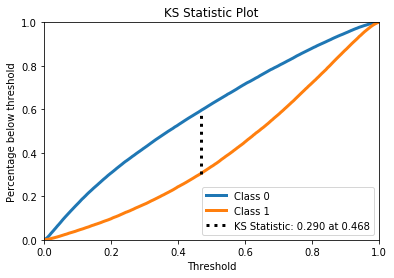

Performance no conjunto de validação:

Accuracy:         0.6437
Recall:           0.6628
Precision:        0.6384
F1:               0.6504
AUROC:            0.6908
AUPR:             0.6578


In [ ]:
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)
mlp_clf.fit(X_train, y_train)
mlp_pred_class = mlp_clf.predict(X_val)
mlp_pred_scores = mlp_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Treinando uma rede SVM (Support Vector Machine): 
Aqui usaremos a terceira partição de dados.

In [ ]:
#GETTING THE DATA FOR SVM: NOW, WE WILL USE THE 3TH PARTITION OF DATA. DON'T NEED TO GET TEST DATA AGAIN.
#get train data
downloaded = drive.CreateFile({'id':id3_train}) 
downloaded.GetContentFile('train_data_3.csv')  
train_data = pd.read_csv('train_data_3.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id3_valid}) 
downloaded.GetContentFile('val_data_3.csv')  
val_data = pd.read_csv('val_data_3.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

feito


In [ ]:
#Treinando a rede SVM
svc_clf = SVC(probability=True, kernel='rbf', gamma=1, C=1)  # Modifique aqui os hyperparâmetros
svc_clf.fit(X_train, y_train)
svc_pred_class = svc_clf.predict(X_val)
svc_pred_scores = svc_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, svc_pred_class, svc_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Treinando com Gradient Boosting:
Usaremos a quarta partição dos dados.

In [ ]:
#GETTING THE DATA FOR GRADIENT BOOSTING: NOW, WE WILL USE THE 4TH PARTITION OF DATA. 
#get train data
downloaded = drive.CreateFile({'id':id4_train}) 
downloaded.GetContentFile('train_data_4.csv')  
train_data = pd.read_csv('train_data_4.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id4_valid}) 
downloaded.GetContentFile('val_data_4.csv')  
val_data = pd.read_csv('val_data_4.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

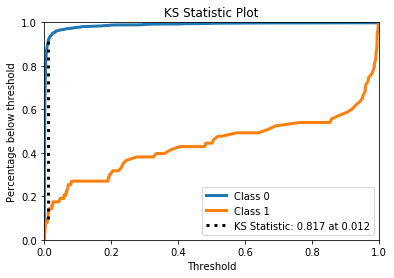


Accuracy:         0.9811
Recall:           0.5556
Precision:        0.7955
F1:               0.6542
AUROC:            0.9489
AUPR:             0.6230


In [ ]:
gb_clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, max_depth=3, 
                                    min_samples_split=2, min_samples_leaf=1, subsample=1.0, verbose=0)
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Implementando uma *Random Forest:*

In [ ]:
#GETTING THE DATA FOR RANDOM FOREST: NOW, WE WILL USE THE 5TH PARTITION OF DATA.
#get train data
downloaded = drive.CreateFile({'id':id5_train}) 
downloaded.GetContentFile('train_data_5.csv')  
train_data = pd.read_csv('train_data_5.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id5_valid}) 
downloaded.GetContentFile('val_data_5.csv')  
val_data = pd.read_csv('val_data_5.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Dimensao do vetor de entrada
input_dim = X_train.shape[1]

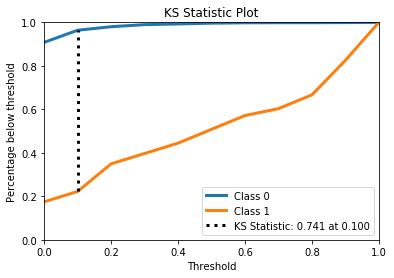

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=10,min_samples_leaf=1, verbose=0)  # Modifique aqui os hyperparâmetros
rf_clf.fit(X_train, y_train)
rf_pred_class = rf_clf.predict(X_val)
rf_pred_scores = rf_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
#print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Implementando uma *Ensemble:*

In [ ]:
#GETTING THE DATA FOR RANDOM FOREST: NOW, WE WILL USE THE 1TH PARTITION OF DATA. #we need to get more partition
#get train data
downloaded = drive.CreateFile({'id':id1_train}) 
downloaded.GetContentFile('train_data_1.csv')  
train_data = pd.read_csv('train_data_1.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id1_valid}) 
downloaded.GetContentFile('val_data_1.csv')  
val_data = pd.read_csv('val_data_1.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Dimensao do vetor de entrada
input_dim = X_train.shape[1]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


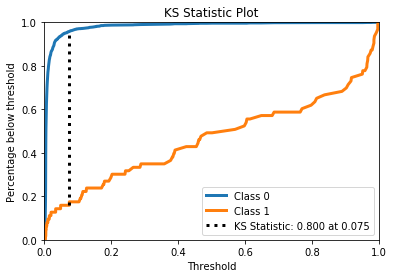


Accuracy:         0.9801
Recall:           0.5079
Precision:        0.8000
F1:               0.6214
AUROC:            0.9403
AUPR:             0.7083


In [ ]:
mlp_ens_clf = KerasClassifier(build_fn=create_sklearn_compatible_model,
                              batch_size=64, epochs=50, verbose=0)
svc_ens_clf = SVC(probability=True, kernel='rbf', gamma=1, C=1) #modifique os hiperparâmetros
gb_ens_clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, max_depth=3, 
                                    min_samples_split=2, min_samples_leaf=1, subsample=1.0, verbose=0)
rf_ens_clf = RandomForestClassifier(n_estimators=200) #modifique os hiperparâmetros
ens_clf = VotingClassifier([('mlp', mlp_ens_clf), ('svm', svc_ens_clf), ('gb', gb_ens_clf), ('rf', rf_ens_clf)], 
                           voting='soft')

ens_clf.fit(X_train, y_train)
ens_pred_class = ens_clf.predict(X_val)
ens_pred_scores = ens_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, ens_pred_class, ens_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

Implementando uma CNN. (Adicionado por Luana)

In [ ]:
#GETTING THE DATA FOR CNN: NOW, WE WILL USE THE 1TH PARTITION OF DATA. #we need to get more partition
#get train data
downloaded = drive.CreateFile({'id':id1_train}) 
downloaded.GetContentFile('train_data_1.csv')  
train_data = pd.read_csv('train_data_1.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id1_valid}) 
downloaded.GetContentFile('val_data_1.csv')  
val_data = pd.read_csv('val_data_1.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Dimensao do vetor de entrada
input_dim = X_train.shape[1]

In [ ]:
#Modificar código ainda
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors. modify
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_dim))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.fit(X_train, y_train, batch_size=64, epochs=10)
score = model.evaluate(X_test, y_test, batch_size=64)

Implementando uma LSTM. (Adicionado por Luana)

In [ ]:
#GETTING THE DATA FOR CNN: NOW, WE WILL USE THE 1TH PARTITION OF DATA. #we need to get more partition
#get train data
downloaded = drive.CreateFile({'id':id1_train}) 
downloaded.GetContentFile('train_data_1.csv')  
train_data = pd.read_csv('train_data_1.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
#get validation data
downloaded = drive.CreateFile({'id':id1_valid}) 
downloaded.GetContentFile('val_data_1.csv')  
val_data = pd.read_csv('val_data_1.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
#get test data
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_data.csv')  
test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
print('feito')
# Convertendo os dados para arrays em vez de DataFrames
#train data
X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
#validation data
X_val = val_data.iloc[:, :-2].values 
y_val = val_data.iloc[:, -1].values.ravel()
#test data
X_test = test_data.iloc[:, :-2].values 
y_test = test_data.iloc[:, -1].values.ravel()

#Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

#Dimensao do vetor de entrada
input_dim = X_train.shape[1]

In [ ]:
from keras.layers import Embedding
from keras.layers import LSTM

max_features = 1000

model = Sequential()
model.add(Embedding(max_features, output_dim=mudar)) #configure these parameterers
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10)
score = model.evaluate(X_test, y_test, batch_size=128)

Agora analisando a performance final de todos os classificadores treinados e do ensemble no conjunto de teste.

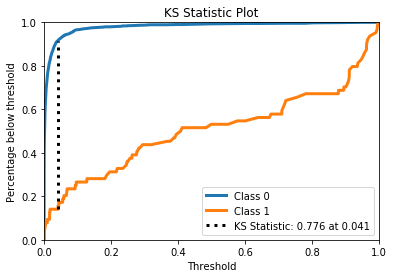

MLP

Accuracy:         0.9761
Recall:           0.4688
Precision:        0.6977
F1:               0.5607
AUROC:            0.9245
AUPR:             0.6357


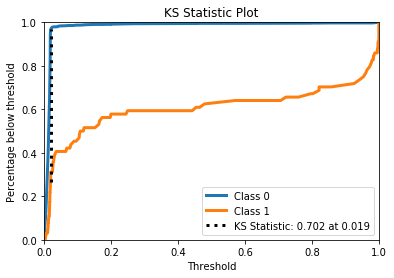



Support Vector Machine

Accuracy:         0.9745
Recall:           0.3594
Precision:        0.7188
F1:               0.4792
AUROC:            0.8764
AUPR:             0.5439


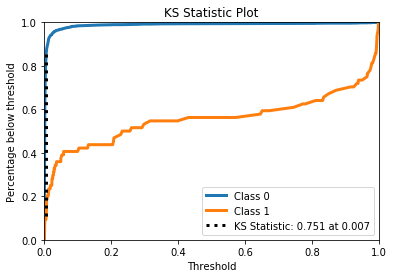



Gradient Boosting

Accuracy:         0.9755
Recall:           0.4375
Precision:        0.7000
F1:               0.5385
AUROC:            0.9164
AUPR:             0.5671


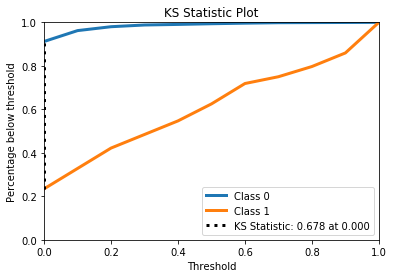



Random Forest

Accuracy:         0.9735
Recall:           0.3750
Precision:        0.6667
F1:               0.4800
AUROC:            0.8609
AUPR:             0.4850


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


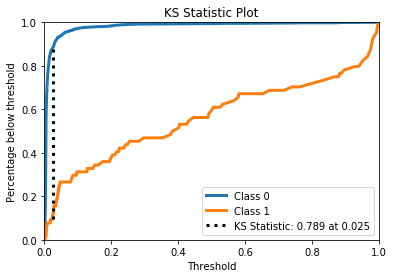



Ensemble

Accuracy:         0.9750
Recall:           0.4062
Precision:        0.7027
F1:               0.5149
AUROC:            0.9397
AUPR:             0.6161


In [ ]:
mlp_pred_class = mlp_clf.predict(X_test)
mlp_pred_scores = mlp_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, mlp_pred_class, mlp_pred_scores)
print('MLP')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

svc_pred_class = svc_clf.predict(X_test)
svc_pred_scores = svc_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, svc_pred_class, svc_pred_scores)
print('\n\nSupport Vector Machine')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

gb_pred_class = gb_clf.predict(X_test)
gb_pred_scores = gb_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, gb_pred_class, gb_pred_scores)
print('\n\nGradient Boosting')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

rf_pred_class = rf_clf.predict(X_test)
rf_pred_scores = rf_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, rf_pred_class, rf_pred_scores)
print('\n\nRandom Forest')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

ens_pred_class = ens_clf.predict(X_test)
ens_pred_scores = ens_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, ens_pred_class, ens_pred_scores)
print('\n\nEnsemble')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [ ]:
#Falta concluir
def get_data(id_train, id_valid, id_test, partition):
    """This function get the data from PyDrive, convert to arrays and normalize the data. Returns 
    X_train, y_train, X_val, y_val, X_test, y_test"""

    #GETTING THE DATA FOR CNN: NOW, WE WILL USE THE 1TH PARTITION OF DATA. #we need to get more partition
    #get train data
    downloaded = drive.CreateFile({'id':id_train}) 
    downloaded.GetContentFile('train_data_1.csv')  
    train_data = pd.read_csv('train_data_1.csv', index_col=0) # Dataset of train is now stored in a Pandas Dataframe
    #get validation data
    downloaded = drive.CreateFile({'id':id_valid}) 
    downloaded.GetContentFile('val_data_1.csv')  
    val_data = pd.read_csv('val_data_1.csv', index_col=0) # Dataset of validation is now stored in a Pandas Dataframe
    #get test data
    downloaded = drive.CreateFile({'id':id_test}) 
    downloaded.GetContentFile('test_data.csv')  
    test_data = pd.read_csv('test_data.csv', index_col=0) # Dataset of test is now stored in a Pandas Dataframe
    print('feito')
    # Convertendo os dados para arrays em vez de DataFrames
    #train data
    X_train = train_data.iloc[:, :-2].values #select all lines, select the 0 to third-to-last column.
    y_train = train_data.iloc[:, -1].values.ravel() #select all lines, select the last column.
    #validation data
    X_val = val_data.iloc[:, :-2].values 
    y_val = val_data.iloc[:, -1].values.ravel()
    #test data
    X_test = test_data.iloc[:, :-2].values 
    y_test = test_data.iloc[:, -1].values.ravel()

    #Normalizando os dados
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test